# MNIST CNN

## Libraries

In [ ]:
import torch
print(torch.__version__)

2.3.0+cu121


In [ ]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torchmetrics

import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

## Data Visualisation and Pre-Processing

* Perform Data-Augmentation

In [ ]:
# Define transformations

transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation within [-10, 10] degrees
    transforms.RandomCrop(28, padding=4),  # Randomly crop image with padding
    transforms.ToTensor(),  # Convert tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the image with mean and std
    # transforms.Lambda(lambda x: x.unsqueeze(0))  # Add a channel dimension
])

In [ ]:
# Download MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 71567259.58it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 23859699.39it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




100%|██████████| 1648877/1648877 [00:00<00:00, 93421380.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3794170.24it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_dataset.data.shape, test_dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
# Targer classes
train_dataset.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

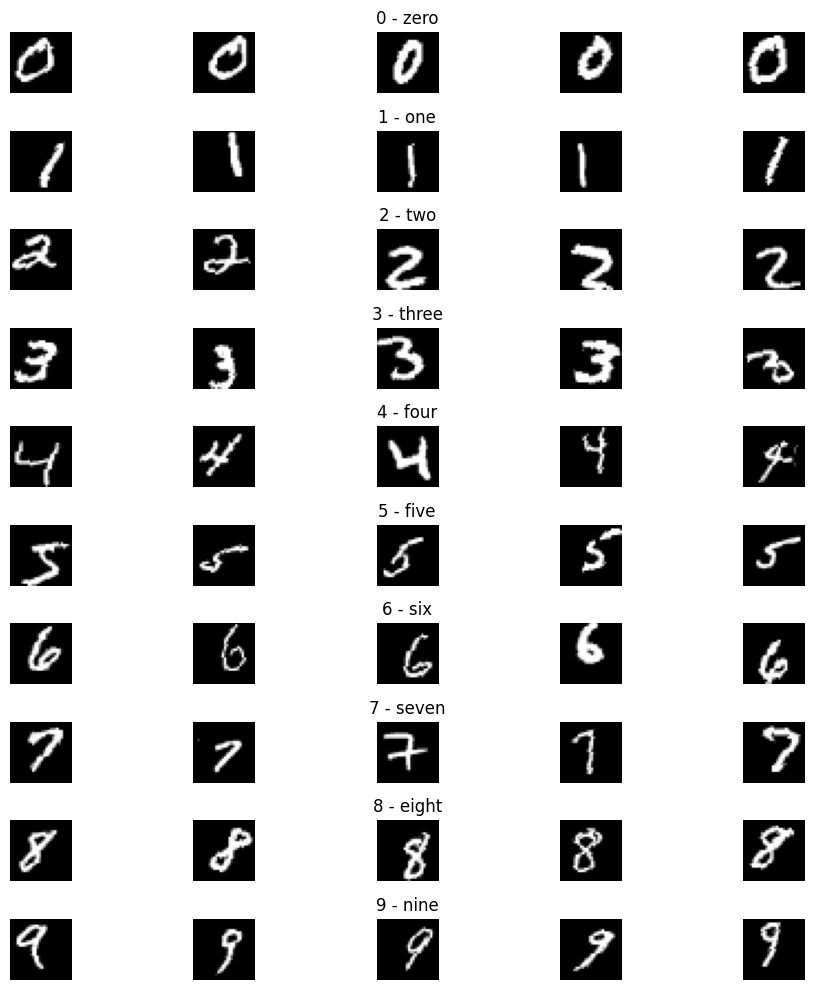

In [ ]:
# Number of rows reprsenting each class
# Number of columns meaning how many images of each class
fig, axes = plt.subplots(nrows=len(train_dataset.classes), ncols=5, figsize=(10, 10))

for i, cls in enumerate(train_dataset.classes):
  cls_idx = train_dataset.class_to_idx[cls]
  # Get images which match the label
  cls_samples = []
  count = 0
  for img, label in train_dataset:
      if label == cls_idx:
          cls_samples.append(img)
          axes[i, count].imshow(cls_samples[count][0], cmap='gray')
          axes[i, count].axis('off')
          count += 1
      # Add title to a row to 3rd count
      if count == 2:
        axes[i, count].set_title(cls)
      # Only five images of each class
      if count == 5:
          break

plt.tight_layout()
plt.show()

* I am going to create a validata data from training making it a 60/20/20 split

In [ ]:
# Define indices
indices = list(range(train_dataset.data.shape[0]))

# Random shuffling of indices
np.random.shuffle(indices)

# Split indices for validation and test
val_idx, train_idx= indices[:10000], indices[10000:]

In [ ]:
# Define samplers
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=64, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the size of each set
print(f"Number of training examples: {len(train_loader.sampler)}")
print(f"Number of validation examples: {len(val_loader.sampler)}")
print(f"Number of test examples: {len(test_loader.sampler)}")

Number of training examples: 50000
Number of validation examples: 10000
Number of test examples: 10000


In [ ]:
def get_classes_distribution(data_loader):
    label_counts = {}

    # Iterate over the DataLoader to collect the labels
    for _, labels in data_loader:
        for label in labels:
            label = label.item()
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

    # Get total number of samples
    total_samples = sum(label_counts.values())

    # Print the count and percentage for each label
    for label, count in label_counts.items():
        percent = (count / total_samples) * 100
        print("{}:   {} or {:.2f}%".format(label, count, percent))

get_classes_distribution(train_loader)

5:   4557 or 9.11%
2:   4935 or 9.87%
8:   4794 or 9.59%
6:   4945 or 9.89%
4:   4872 or 9.74%
3:   5158 or 10.32%
7:   5204 or 10.41%
1:   5654 or 11.31%
9:   4958 or 9.92%
0:   4923 or 9.85%


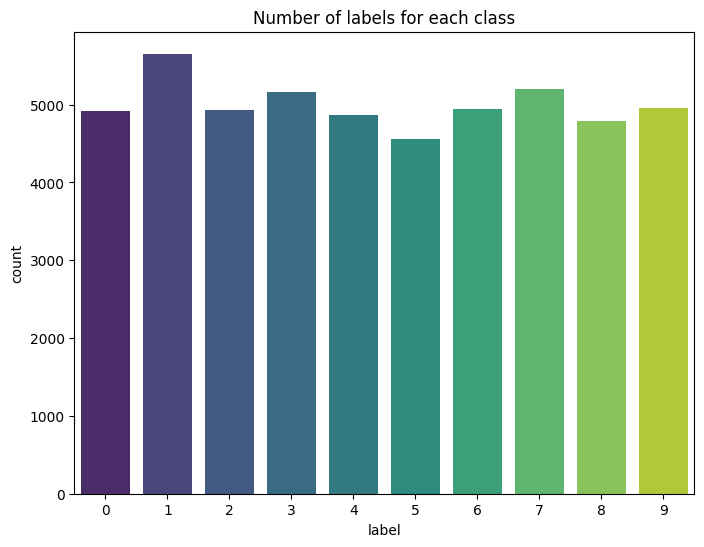

In [ ]:
def plot_class_distribution(data_loader):
    # Collect all labels from the DataLoader
    all_labels = []
    for _, labels in data_loader:
        all_labels.extend(labels.numpy())  # Assuming labels are tensors, convert to numpy

    # Convert the labels to a pandas DataFrame
    labels_df = pd.DataFrame(all_labels, columns=['label'])

    # Plot the distribution using Seaborn
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    g = sns.countplot(data=labels_df, x='label', palette='viridis', ax=ax)
    g.set_title("Number of labels for each class")
    plt.show()

# Example usage with your DataLoader
plot_class_distribution(train_loader)

## Device Agnostics

In [ ]:
# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Explicit EarlyStopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

## Model-Architecture

In [ ]:
# Define the architecture of the neural network model
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 32, 3),  # 28 28 1 -> 26 26 32
      nn.ReLU(),
      nn.MaxPool2d(2, 2)    # 26 26 32 -> 13 13 32
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(32, 64, 3), # 13 13 32 -> 11 11 64
      nn.ReLU(),
      nn.MaxPool2d(2, 3)    # 11 11 64 -> 4 4 64
    )

    self.fc_layers = nn.Sequential(
      nn.Linear(4*4*64, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = torch.flatten(x, 1)  # Flatten the tensor
    x = self.fc_layers(x)
    return x

In [ ]:
# Initialize the model
model = CNNModel().to(device)

# Define loss function, optimizer, and learning rate scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# Display the model architecture
model

CNNModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 64, 11, 11]          18,496
              ReLU-5           [-1, 64, 11, 11]               0
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 128]         131,200
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
          Dropout-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 158,922
Trainable params:

##Model-Training

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
if device == "cuda":
    torch.cuda.manual_seed(42)

In [ ]:
class DeviceDataLoader:
  def __init__(self, data_loader, device):
    self.data_loader = data_loader
    self.device = device

  def __iter__(self):
    self.data_loader_iter = iter(self.data_loader)
    return self

  def __next__(self):
    X_batch, y_batch = next(self.data_loader_iter)
    return X_batch.to(self.device), y_batch.to(self.device)

  def __len__(self):
    return len(self.data_loader)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

early_stopping = EarlyStopping(patience=3, verbose=True)

epochs = 100
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)  # Initialize train accuracy

  for X_batch, y_batch in train_loader:
    y_pred = model(X_batch)

    loss = loss_fn(y_pred, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_acc.update(y_pred, y_batch)

  train_losses.append(running_loss / len(train_loader))
  train_accuracies.append(train_acc.compute().item())

  model.eval()
  lossu = 0.0
  val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

  with torch.inference_mode():
    for X_val, y_val in val_loader:
      y_val_pred = model(X_val)
      loss = loss_fn(y_val_pred, y_val)
      lossu += loss.item()

      val_acc.update(y_val_pred, y_val)

  val_losses.append(lossu / len(val_loader))
  val_accuracies.append(val_acc.compute().item())

  if epoch % 5 == 0:
    print(f"Epoch: {epoch}, Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}")

  early_stopping(val_losses[-1])
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch: 0, Loss: 0.636335867616679, Val Loss: 0.20562543634586272, Train Acc: 0.7878599762916565, Val Acc: 0.9384999871253967
Epoch: 5, Loss: 0.11545506861034657, Val Loss: 0.07102686919681253, Train Acc: 0.9659199714660645, Val Acc: 0.9775999784469604
EarlyStopping counter: 1 out of 3
Epoch: 10, Loss: 0.09022234883927562, Val Loss: 0.059245958965817455, Train Acc: 0.9731400012969971, Val Acc: 0.9815999865531921
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 1 out of 3
Epoch: 15, Loss: 0.07439551320548653, Val Loss: 0.05506516730963033, Train Acc: 0.9771999716758728, Val Acc: 0.9837999939918518
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
EarlyStopping counter: 1 out of 3
Epoch: 20, Loss: 0.06772117017898732, Val Loss: 0.04703684980446431, Train Acc: 0.9812600016593933, Val Acc: 0.9864000082015991
EarlyStopping counter: 2 out of 3
EarlyStopping counter: 1 out of 3
EarlyStopping counter: 2 out of 3
EarlyStopping counter: 3 out of 3
Early stopping


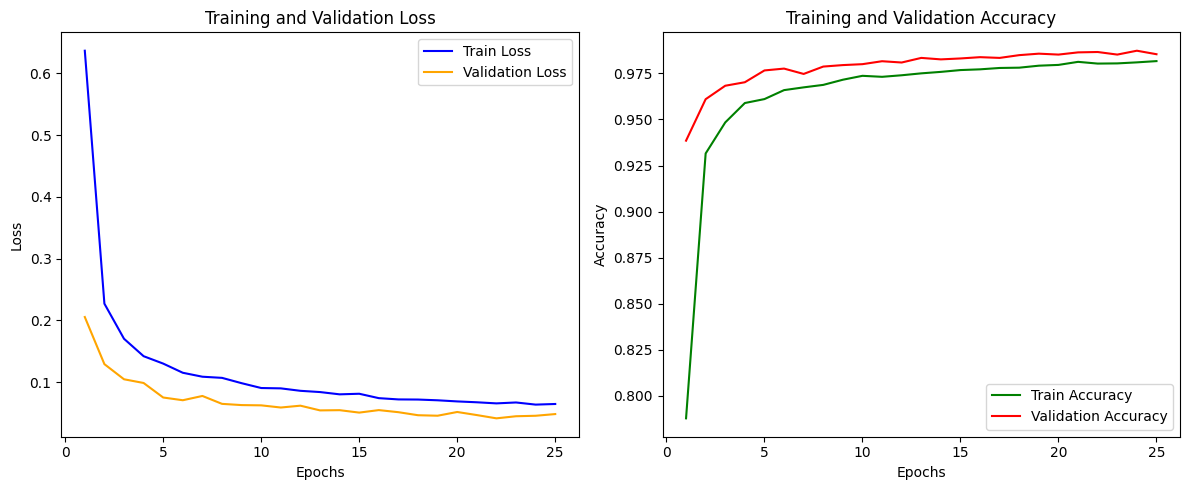

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the loss curves
ax1.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', color='blue')
ax1.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend(loc='upper right')

# Plot the accuracy curves
ax2.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy', color='green')
ax2.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

##Model-Evaluation

In [ ]:
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
model.eval()
lossu = 0.0
test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

with torch.inference_mode():
  for X_test, y_test in test_loader:
    y_test_pred = model(X_test)
    loss = loss_fn(y_test_pred, y_test)
    lossu += loss.item()
    test_acc.update(y_test_pred, y_test)

print(f"Test Loss: {lossu / len(test_loader)}")
print(f"Test Accuracy: {test_acc.compute().item()}")

Test Loss: 0.04369722633034207
Test Accuracy: 0.9861000180244446


In [ ]:
model.eval()
y_test_all = []
y_test_pred_all = []

with torch.inference_mode():
  for X_test, y_test in test_loader:
    y_test_all.append(y_test)
    y_test_pred = model(X_test)
    y_test_pred = torch.softmax(y_test_pred, dim=1)
    y_test_pred_all.append(y_test_pred)

y_test_all = torch.cat(y_test_all).cpu().numpy()
y_test_pred_all = torch.cat(y_test_pred_all).cpu().numpy()

In [ ]:
y_test_pred_all_ = []
for i in y_test_pred_all:
  y_test_pred_all_.append(np.argmax(i))

In [ ]:
# Generate the classification report
report = classification_report(y_test_all, y_test_pred_all_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



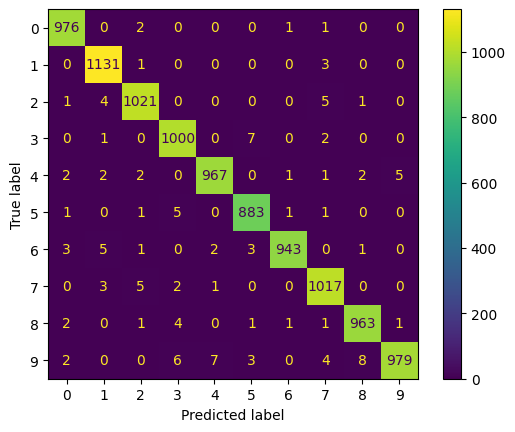

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_all, y_test_pred_all_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
cm_display.plot()
plt.show()